# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW04] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улyчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import random
from itertools import cycle
from typing import Tuple

import numpy
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
SEED = 7
random.seed(SEED)
numpy.random.seed(SEED)

In [3]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = numpy.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответствовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [4]:
class Perceptron:

    w = None
    _x = None
    _y = None
    _true_classes = None

    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : numpy.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответствовать константе,
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """
        self._iterations = iterations

    @staticmethod
    def _binarize_labels(y: numpy.ndarray) -> Tuple[numpy.ndarray, numpy.ndarray]:
        true_classes, indexes = numpy.unique(y, return_inverse=True)
        if len(true_classes) != 2:
            raise ValueError(f"Labels must contain 2 different values")
        return numpy.array([-1, 1])[indexes], true_classes

    def _prepare_x_y(self, x: numpy.ndarray, y: numpy.ndarray):
        ones = numpy.ones((x.shape[0], 1), dtype=x.dtype)
        self._x = numpy.hstack((ones, x))
        self._y, self._true_classes = self._binarize_labels(y)
        self._y = self._y.astype(numpy.int8)

    def fit(self, x: numpy.ndarray, y: numpy.ndarray):
        """
        Обучает простой перцептрон. 
        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.
        
        Parameters
        ----------
        x : numpy.ndarray
            Набор данных, на котором обучается перцептрон.
        y: numpy.ndarray
            Набор меток классов для данных.
        
        """
        self._prepare_x_y(x, y)
        self.w = numpy.zeros(self._x.shape[1])
        n_updates = 0
        for x_i, y_i in cycle(zip(self._x, self._y)):
            if numpy.sign(self.w.dot(x_i)) != y_i:
                self.w += y_i * x_i
                n_updates += 1
                if n_updates == self._iterations:
                    break

    def predict(self, x: numpy.ndarray) -> numpy.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        x : numpy.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : numpy.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        if self.w is None:
            raise RuntimeError("Fit perceptron before trying to predict")
        prediction = numpy.sign(x.dot(self.w[1:]) + self.w[0])
        prediction[prediction == 0] = prediction[0]
        unique, indexes = numpy.unique(prediction, return_inverse=True)
        return self._true_classes[indexes]

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

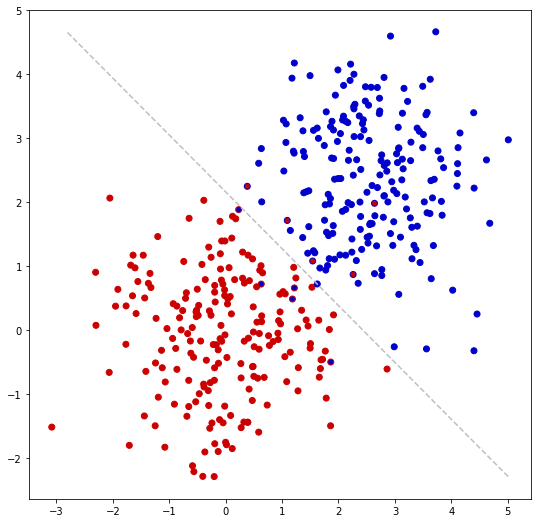

In [5]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, numpy.array(c.predict(X)), c.w)

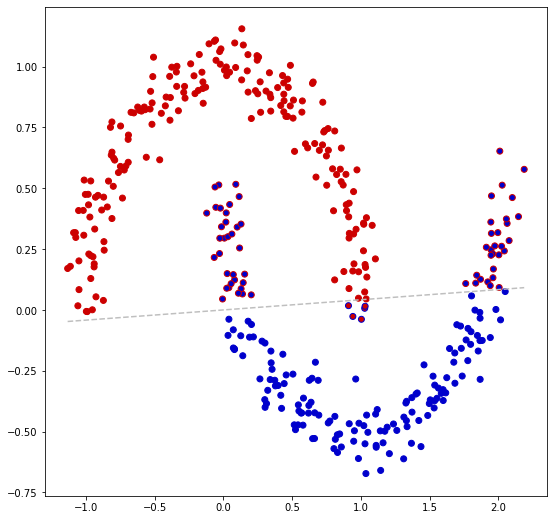

In [6]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, numpy.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответствовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [7]:
class PerceptronBest(Perceptron):
    
    def fit(self, x: numpy.ndarray, y: numpy.ndarray):
        """
        Обучает перцептрон.

        Для этого сначала инициализирует веса перцептрона, 
        а затем обновляет их в течении iterations итераций.

        При этом в конце обучения оставляет веса, 
        при которых значение accuracy было наибольшим.
        
        Parameters
        ----------
        x : numpy.ndarray
            Набор данных, на котором обучается перцептрон.
        y: numpy.ndarray
            Набор меток классов для данных.
        
        """
        self._prepare_x_y(x, y)
        w = numpy.zeros(self._x.shape[1])
        min_errors = self._x.shape[0]
        next_update = 0
        for _ in range(self._iterations):
            error_indexes = numpy.sign(self._x @ w) != self._y
            n_errors = error_indexes.sum()
            if n_errors < min_errors:
                min_errors = n_errors
                self.w = w.copy()
            while not error_indexes[next_update]:
                next_update = (next_update + 1) % self._x.shape[0]
            w += self._x[next_update] * self._y[next_update]

        last_iter_error_indexes = numpy.sign(self._x @ w) != self._y
        if last_iter_error_indexes.sum() < min_errors:
            self.w = w.copy()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

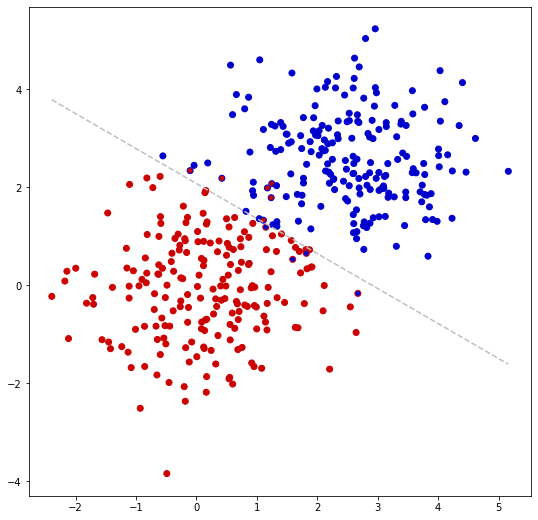

In [8]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, numpy.array(c.predict(X)), c.w)

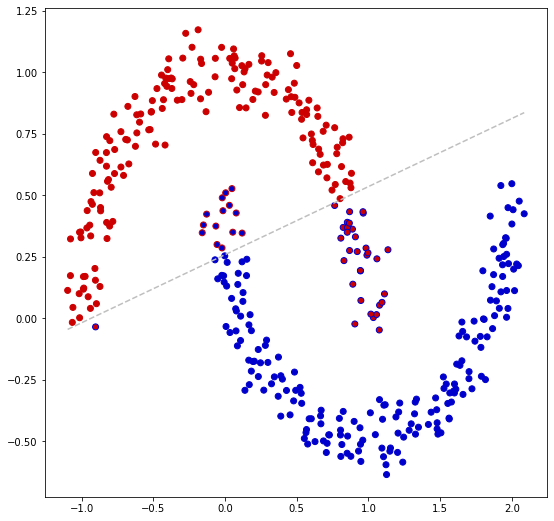

In [9]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, numpy.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [10]:
def transform_images(images: numpy.ndarray) -> numpy.ndarray:
    """
    Переводит каждое изображение в вектор из двух элементов.

    Использует 2 заранее заданных ядра -- kernel1 и kernel5.
    Ядро состоит из 0 и 1.
    К каждой картинке применяется ядро:
        1. Покомпонентное умножение значений картинки на значение ядра
        2. Значение признака -- среднее получившегося умножения
    Интуитивно, смотрим по маске соответствие пикселей нужному числу.
        
    Parameters
    ----------
    images : numpy.ndarray
        Трехмерная матрица с черное-белыми изображениями.
        Её размерность: (n_images, image_height, image_width).

    Return
    ------
    numpy.ndarray
        Двумерная матрица с преобразованными изображениями.
        Её размерность: (n_images, 2).
    """
    bs, h, w = images.shape
    kernel1 = numpy.array([
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
    ])
    kernel5 = numpy.array([
        [0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 1, 1, 1, 0, 0, 0],
    ])
    result = numpy.empty((bs, 2))
    result[:, 0] = (images * kernel1).mean(axis=(1, 2))
    result[:, 1] = (images * kernel5).mean(axis=(1, 2))
    return result

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = numpy.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= numpy.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что перцептрон детерминирован, а выборка должна разбиваться без перемешивания__

In [11]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

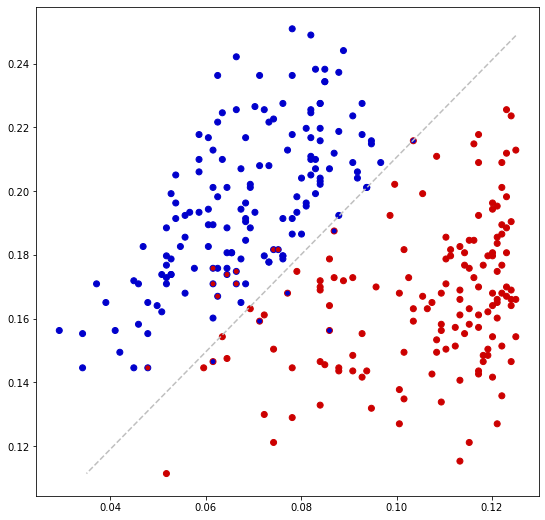

Accuracy: 0.9863013698630136


In [12]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, numpy.array(c.predict(X_train)), c.w)
print("Accuracy:", numpy.mean(c.predict(X_test) == y_test))

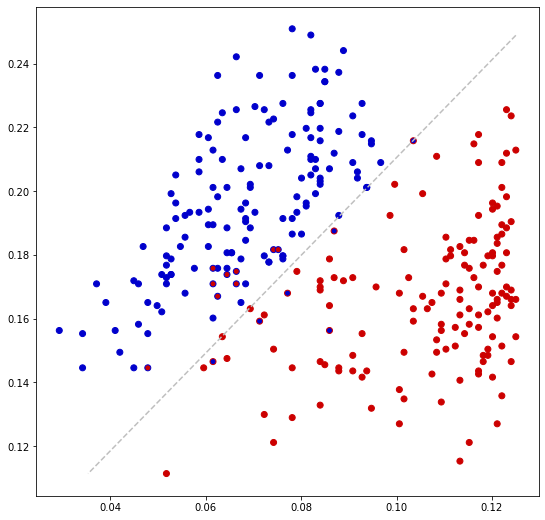

Accuracy: 0.9863013698630136


In [13]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, numpy.array(c.predict(X_train)), c.w)
print("Accuracy:", numpy.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [14]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(numpy.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", numpy.mean(accs))

Mean accuracy: 0.6780250843807986


In [15]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(numpy.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", numpy.mean(accs))


Mean accuracy: 0.794891418526379
